# Train TCVAE
This notebook trains a new model and saves various artifacts, such as model architecture, model weights, animations, and plots to an experiment directory in `/experiments/`.

In [1]:
import os
import sys
import warnings
import argparse as ap
warnings.filterwarnings('ignore')

import git
import matplotlib.pyplot as plt

import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (
    TerminateOnNaN, EarlyStopping, ReduceLROnPlateau, CSVLogger)

sys.path.append(git.Repo(search_parent_directories=True).working_dir)

from tcvae.models import TCVAE
from tcvae.models.square_128 import (
    make_encoder_7_convs, make_decoder_7_deconvs)
from tcvae.losses import convert_loss_dict_keys
from tcvae.data import ImageDataGenerator, crop_center_square
from tcvae.data.augmentation import *
from tcvae.utils import read_yaml, write_yaml
from tcvae.callbacks import (
    ReconstructionCheck, LatentTraversalCheck, LatentDistributionLogging,
    TCVAECheckpoint)
from tcvae.visualization import plot_img

from config import EXPERIMENTS_DIR, YAML_DIR, TRAIN_DATA_DIR

%load_ext autoreload
%autoreload 2

# Parameters
- **Saving parameters** determine what artifacts are saved and where
- **Model hyperparameters** determine model architecture
- **Training hyperparameters** determine how training proceeds
- **Logging parameters** determine what monitoring information is saved throughout training process

In [21]:
# Saving parameters
EXPERIMENT_NAME = 'experiment-01'
OVERWRITE = True

# Training hyperparameters
N_EPOCHS = 1000
BATCH_SIZE = 2 ** 9

# Logging parameters
N_DIST_LOG_IMGS = 2 ** 10
N_RECON_CHECK_IMGS = 2 ** 3
N_VAL_IMGS = 2 ** 10

# Setup paths

In [7]:
experiment_dir = EXPERIMENTS_DIR / EXPERIMENT_NAME
experiment_dir.mkdir(exist_ok=True, parents=True)

training_dir = experiment_dir / 'training'
training_dir.mkdir(exist_ok=True, parents=True)

recon_check_dir = training_dir / 'reconstruction-check'
recon_check_dir.mkdir(exist_ok=True, parents=True)

traversal_check_dir = training_dir / 'traversal-check'
traversal_check_dir.mkdir(exist_ok=True, parents=True)

model_dir = experiment_dir / 'model'

latent_dist_history_log_file = \
    training_dir / 'latent-distribution-history.csv'
loss_history_log_file = training_dir / 'loss-history.csv'

# Load data generators
The training data generator applies random data augmentation transformations while the validation data generator does not. We use the following image data augmentation techniques:
- **RandomColorMixer**: applies random moderate contrast stretching and brightness shifting to each color channel independently. This causes image temperature and tints to change.
- **RandomIntensifier**: applies random contrast stretching and brightness shifting to entire image. This creates variations in contrast and brightness.
- **RandomFlipper**: randomly flips the image along its horizontal axis.
- **RandomSquareCropper**: crops the image to a randomly located and sized square.
- **RandomRotator**: randomly rotates the image about the center.

The order in which the augmentors are passed into the data generator matters. That is, `[f, g, h] implies f(g(h(x)))`.

In [8]:
augmentors = [
    RandomColorMixer(), RandomIntensifier(), RandomFlipper(),
    RandomSquareCropper(), RandomRotator()]
train_datagen = ImageDataGenerator(
    TRAIN_DATA_DIR, BATCH_SIZE, transformers=augmentors, n_processes=1)
print(train_datagen, end='\n\n')

val_datagen = ImageDataGenerator(
    TRAIN_DATA_DIR, BATCH_SIZE, transformers=[crop_center_square], n_processes=1)
print(val_datagen)

Image Data Generator
--------------------
Data path: /home/jovyan/tcvae/data/train
Number of files: 202599
Parallelization: 1

Image Data Generator
--------------------
Data path: /home/jovyan/tcvae/data/train
Number of files: 202599
Parallelization: 1


Let's take a peek at what augmented images look like.

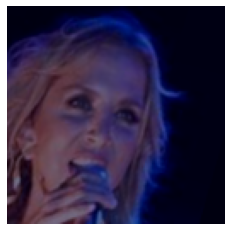

In [9]:
sample_train_img = train_datagen.load_n_images(1)[0]
plot_img(sample_train_img)

Let's sample out some images to use for checking reconstruction and traversal quality as the model trains.

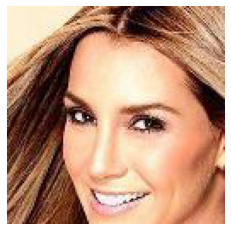

In [10]:
recon_check_imgs = val_datagen.load_n_images(N_RECON_CHECK_IMGS, random=False)
traversal_check_img = val_datagen.load_n_images(1, random=False).squeeze()
plot_img(traversal_check_img)

To log the means and variances of latent distributions, we'll want a larger number of sample images from the training set (since latent components may cover some of the axes of variation introduced through data augmentation).

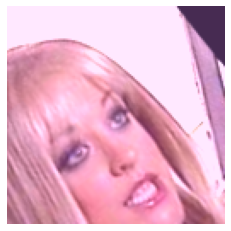

In [11]:
dist_log_imgs = train_datagen.load_n_images(1024, random=True)
plot_img(dist_log_imgs[0])

# Define model

In [22]:
if model_dir.exists() and not OVERWRITE:
    print('Detected existing model.')
    model = TCVAE.load(model_dir)
    model.compile(optimizer=Adam(lr=0.001))
else:
    K.clear_session()
    loss_dict = dict(
        total_correlation=64,
        sigmoid_cross_entropy=0.5,
        dssim=0.5,
        mutual_information_index=0.,
        dimensional_kl=1.)
    loss_dict = convert_loss_dict_keys(loss_dict)
    encoder = make_encoder_7_convs(
        activation='relu', num_latents=64, batch_normalization=True,
        filters=(32, 64, 128, 256, 512, 1024))
    decoder = make_decoder_7_deconvs(
        activation='relu', num_latents=64, batch_normalization=True,
        filters=(1024, 512, 256, 128, 64, 32))
    model = TCVAE(
        encoder, decoder, loss_dict, batch_size=train_datagen.batch_size,
        dataset_size=train_datagen.n_samples)
    optimizer = Adam(lr=0.001)
    model.compile(optimizer=optimizer)

total_correlation: 64
sigmoid_cross_entropy: 0.5
dssim: 0.5
mutual_information_index: 0.0
dimensional_kl: 1.0


# Define callbacks

In [24]:
reconstruction_checker = ReconstructionCheck(
    recon_check_imgs, recon_check_dir)
traversal_checker = LatentTraversalCheck(
    traversal_check_img, traversal_check_dir)
dist_logger = LatentDistributionLogging(
    latent_dist_history_log_file, dist_log_imgs, verbose=True, overwrite=OVERWRITE)
checkpointer = TCVAECheckpoint(model=model, monitor='loss', model_dir=model_dir)
nan_terminator = TerminateOnNaN()
csv_logger = CSVLogger(loss_history_log_file.as_posix(), append=not OVERWRITE)
lr_reducer = ReduceLROnPlateau(
    verbose=2, monitor='loss', factor=0.5, patience=3, min_delta=0, min_lr=0.)
early_stopper = EarlyStopping(
    verbose=2, restore_best_weights=True, monitor='loss', patience=10)
callbacks = [
    reconstruction_checker, traversal_checker, dist_logger,
    nan_terminator, csv_logger, lr_reducer, early_stopper, checkpointer]

# Save details

In [23]:
summary = list()
model.encoder.summary(print_fn=lambda x: summary.append(x))
decoder_summary_file = experiment_dir / 'summary-encoder.txt'
decoder_summary_file.write_text('\n'.join(summary))

summary = list()
model.decoder.summary(print_fn=lambda x: summary.append(x))
decoder_summary_file = experiment_dir / 'summary-decoder.txt'
decoder_summary_file.write_text('\n'.join(summary))

loss_names_dict = {fn.__name__: coef for fn, coef in loss_dict.items()}
loss_yaml_file = experiment_dir / 'losses.yaml'
write_yaml(loss_yaml_file, loss_names_dict)

# Train model

In [25]:
# Keras model needs jump-starting for some reason
train_sample = train_datagen.load_n_images(1024)
model.fit(
    train_sample, train_sample, batch_size=BATCH_SIZE,
    epochs=1, callbacks=[checkpointer])

 512/1024 [==============>...............] - ETA: 5s - loss: 41811.9492 - total_correlation: 27.3943 - sigmoid_cross_entropy: 36595.9570 - dssim: 43465.1758 - mutual_information_index: 6.2481 - dimensional_kl: 28.1450loss improved from inf to 42385.001953125
Saving checkpoint at /home/jovyan/tcvae/experiments/experiment-01/model
1024/1024 [==============================] - 8s 8ms/sample - loss: 42385.0020 - total_correlation: 40.6930 - sigmoid_cross_entropy: 36318.0156 - dssim: 42872.3984 - mutual_information_index: 6.2481 - dimensional_kl: 185.4403


In [26]:
train_datagen.batch_size = BATCH_SIZE
model.fit_generator(
    train_datagen, callbacks=callbacks, epochs=N_EPOCHS,
    use_multiprocessing=True, workers=8, max_queue_size=8)

# csv_logger.append=True
# dist_logger.overwrite=False

Epoch 1/1000
395/396 [============================>.] - ETA: 1s - loss: 30830.8858 - total_correlation: 14.4566 - sigmoid_cross_entropy: 28719.2617 - dssim: 29470.7793 - mutual_information_index: 5.6422 - dimensional_kl: 810.6390Latent sigmas epoch:
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan]
loss improved from 42385.001953125 to 30820.270295730745
Saving checkpoint at /home/jovyan/tcvae/experiments/experiment-01/model
396/396 [==============================] - 481s 1s/step - loss: 30820.2703 - total_correlation: 14.4558 - sigmoid_cross_entropy: 28713.8633 - dssim: 29457.9883 - mutual_information_index: 5.6437 - dimensional_kl: 809.1656
Epoch 2/1000
395/396 [============================>.] - ETA: 1s - loss: 25120.3005 - total_correlation: 17.6809 - sigmoid_cross_entropy: 2

Process Keras_worker_ForkPoolWorker-24:
Process Keras_worker_ForkPoolWorker-23:
Process Keras_worker_ForkPoolWorker-20:
Process Keras_worker_ForkPoolWorker-22:
Process Keras_worker_ForkPoolWorker-19:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Process Keras_worker_ForkPoolWorker-18:
  File "/home/jovyan/my-conda-envs/tcvae/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/jovyan/my-conda-envs/tcvae/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/jovyan/my-conda-envs/tcvae/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/jovyan/my-conda-envs/tcvae/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/home/jovyan/my-conda-envs/

KeyboardInterrupt: 

  File "/home/jovyan/my-conda-envs/tcvae/lib/python3.7/site-packages/scipy/ndimage/filters.py", line 302, in gaussian_filter
    output[...] = input[...]
KeyboardInterrupt
Process Keras_worker_ForkPoolWorker-21:
Traceback (most recent call last):
  File "/home/jovyan/my-conda-envs/tcvae/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/jovyan/my-conda-envs/tcvae/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/jovyan/my-conda-envs/tcvae/lib/python3.7/multiprocessing/pool.py", line 127, in worker
    put((job, i, result))
  File "/home/jovyan/my-conda-envs/tcvae/lib/python3.7/multiprocessing/queues.py", line 358, in put
    obj = _ForkingPickler.dumps(obj)
  File "/home/jovyan/my-conda-envs/tcvae/lib/python3.7/multiprocessing/reduction.py", line 51, in dumps
    cls(buf, protocol).dump(obj)
KeyboardInterrupt
Exception in thread Thread-14:
Traceback (most recent call last):

In [18]:
# csv_logger.append=True
# dist_logger.overwrite=False

In [22]:
model.model_predict.summary()

Model: "tcvae-predict"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
x (InputLayer)               [(None, 128, 128, 3)]     0         
_________________________________________________________________
encoder (Model)              [(None, 64), (None, 64),  3115744   
_________________________________________________________________
decoder (Model)              (None, 128, 128, 3)       3082851   
Total params: 6,198,595
Trainable params: 6,198,595
Non-trainable params: 0
_________________________________________________________________
